In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [2]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [3]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 28  # Resize images to 28x28

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=28):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize it
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = np.array(label_list)  # Labels: [0, 1, 2, ..., 6] for classification
    return X, y

# Load the images and labels
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Step 1: Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the 80% training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Check the shape of the dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Compute class weights to handle class imbalance
def compute_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(labels), y=labels
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weight_dict

class_weights = compute_class_weights(y_train)

# Data Augmentation for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creating data pipeline for training and validation
train_dataset = train_datagen.flow(X_train, y_train_one_hot, batch_size=16)
val_dataset = val_datagen.flow(X_val, y_val_one_hot, batch_size=16)

# Efficient data pipeline: cache, batch, and prefetch (for training and validation datasets)
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

    # Efficient data pipeline: cache, batch, and prefetch
    train_data = (train_data
                  .cache()
                  .shuffle(buffer_size=1000)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
    
    val_data = (val_data
                .cache()
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

    test_data = (test_data
                 .cache()
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

    return train_data, val_data, test_data

# Set batch size for training
batch_size = 16

# Create the dataset pipeline for efficient data loading
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)


Training set shape: (5608, 28, 28, 3)
Validation set shape: (2404, 28, 28, 3)
Test set shape: (2003, 28, 28, 3)


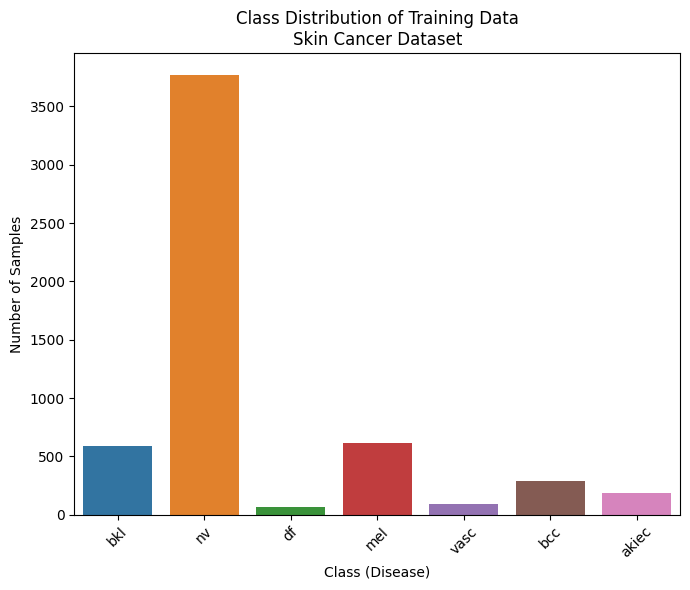

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add disease names for better interpretation
disease_labels = {v: k for k, v in label_mapping.items()}

# Update the plot function to show disease names on the x-axis
def plot_class_distribution(y_original, title, disease_labels):
    y_original_series = pd.Series(y_original)
    
    original_class_dist = y_original_series.value_counts().sort_index()
    
    # Plot the class distribution
    plt.figure(figsize=(7, 6))
    sns.barplot(x=original_class_dist.index, y=original_class_dist.values)
    plt.title(f'Class Distribution of Training Data\n{title}')
    plt.xlabel('Class (Disease)')
    plt.ylabel('Number of Samples')
    plt.xticks(ticks=original_class_dist.index, labels=[disease_labels.get(i, i) for i in original_class_dist.index], rotation=45)
    plt.tight_layout()
    plt.show()

# Call the updated function to plot the class distribution of the original training data
plot_class_distribution(y_train, 'Skin Cancer Dataset', disease_labels)


Random Image from Training Data:


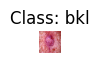

In [6]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to display a random image from the dataset
def display_random_image(X, y, labels, img_size=28):
    # Pick a random index
    random_index = random.randint(0, len(X) - 1)
    
    # Get the image and its corresponding label
    random_img = X[random_index]
    random_label = y[random_index]
    
    # Convert image array back to displayable format (no resizing)
    random_img_display = image.array_to_img(random_img)
    
    # Get the actual image dimensions
    img_height, img_width, _ = random_img.shape
    
    # Set the figure size based on the actual image size (in inches)
    # Convert pixels to inches (assuming 100 dpi by default)
    figsize = (img_width / 100, img_height / 100)
    
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(random_img_display)
    plt.title(f"Class: {labels[random_label]}")
    plt.axis('off')  # Hide axes for better clarity
    plt.show()

# Display a random image from the original dataset
def visualize_random_image(X_train, y_train, labels_reverse, img_size=28):
    print("Random Image from Training Data:")
    display_random_image(X_train, y_train, labels_reverse, img_size)

# Convert label back to its original class name using the 'label_mapping'
labels_reverse = {v: k for k, v in label_mapping.items()}  # Reverse the label mapping

# Visualize a random image from the original training data at actual size
visualize_random_image(X_train, y_train, labels_reverse, img_size=28)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 128  # Latent dimension (size of the compressed representation)

# Encoder (Updated with reduced filters, depthwise separable convolutions, and batch normalization)
encoder = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.SeparableConv2D(16, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (28, 28) -> (14, 14, 16)
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (14, 14) -> (7, 7, 32)
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation (128)
])

# Decoder (Updated to output 28x28 with 'same' padding, using depthwise separable convolutions)
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 32, activation="relu"),  # Upscale to match the desired dimensions
    layers.Reshape((7, 7, 32)),  # Shape after first dense layer
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),  # (14, 14, 32)
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'),  # (28, 28, 16)
    layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='sigmoid'),  # (28, 28, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(28, 28, 3))  # Changed input shape to (28, 28, 3)
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Compile the autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Print model summary to check the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │         201,803 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 3)           │         216,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,510 (1.60 MB)

 Trainable params: 418,350 (1.60 MB)

 Non-trainable params: 160 (640.00 B)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_discriminator(input_shape=(28, 28, 3), num_classes=7):
    model = models.Sequential()

    # First convolutional layer with 16 filters and 'same' padding
    model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # Second convolutional layer with 32 filters and 'valid' padding (matches provided output)
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))  # (28, 28) -> (26, 26)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (26, 26) -> (13, 13)
    model.add(layers.BatchNormalization())
    
    # Third convolutional layer with 32 filters and 'same' padding
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))  # (13, 13) -> (13, 13)

    # Fourth convolutional layer with 64 filters and 'valid' padding
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))  # (13, 13) -> (11, 11)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (11, 11) -> (6, 6)
    model.add(layers.BatchNormalization())
    
    # Flatten the feature maps
    model.add(layers.Flatten())  # (6, 6, 64) -> 2304

    # Dense layer (fully connected) with 64 units
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Fully connected (dense) layer with 32 units
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with Softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output 7 classes
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the discriminator model
num_classes = 7  # Number of classes in the dataset (e.g., 7 for HAM10000 dataset)
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=num_classes)

# Display the model summary
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,055 (539.28 KB)

 Trainable params: 137,831 (538.40 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm

# Assuming you have an autoencoder model that is already trained
# Use the decoder part of the autoencoder as the generator
generator = autoencoder.layers[-2]  # Decoder of the autoencoder
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=7)

# Define the GAN model
def create_gan(generator, discriminator, latent_dim=128):
    # Freeze the discriminator during the generator training
    discriminator.trainable = False

    # Input layer for random noise (latent vector of size 128)
    gan_input = layers.Input(shape=(latent_dim,))
    
    # Use the generator (autoencoder's decoder) to generate images
    x = generator(gan_input)  # Generator generates fake images
    gan_output = discriminator(x)  # Discriminator evaluates the fake image

    # Build the GAN model
    gan = models.Model(gan_input, gan_output)
    
    # Compile the GAN with categorical cross-entropy loss for multi-class classification
    gan.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    return gan

# Loss functions for the autoencoder and discriminator
loss_fn_auto = tf.keras.losses.MeanSquaredError()  # For the autoencoder (reconstruction loss)
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # For discriminator (classification loss)

# Optimizers for autoencoder and discriminator
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Metrics to store losses and accuracies for tracking
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop for GAN
for epoch in range(200):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape(persistent=True) as tape:
            # Pass batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass batch through the discriminator (real vs fake image)
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients to autoencoder
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        # Apply gradients to discriminator
        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 0, Autoencoder Loss: 0.028456781059503555, Discriminator Loss: 1.2046464681625366, Discriminator Accuracy: 0.6673789024353027
Validation - Autoencoder Loss: 0.019949957728385925, Discriminator Loss: 1.1100577116012573, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:42<00:00,  3.43it/s]


Epoch 1, Autoencoder Loss: 0.01861427165567875, Discriminator Loss: 1.0884311199188232, Discriminator Accuracy: 0.6716524362564087
Validation - Autoencoder Loss: 0.016945434734225273, Discriminator Loss: 1.0787533521652222, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:42<00:00,  3.43it/s]


Epoch 2, Autoencoder Loss: 0.013918197713792324, Discriminator Loss: 1.0614837408065796, Discriminator Accuracy: 0.6720085740089417
Validation - Autoencoder Loss: 0.010808922350406647, Discriminator Loss: 1.039608359336853, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:42<00:00,  3.43it/s]


Epoch 3, Autoencoder Loss: 0.008949965238571167, Discriminator Loss: 1.0048383474349976, Discriminator Accuracy: 0.6723646521568298
Validation - Autoencoder Loss: 0.007481853011995554, Discriminator Loss: 0.9983541965484619, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:42<00:00,  3.42it/s]


Epoch 4, Autoencoder Loss: 0.0064302715472877026, Discriminator Loss: 0.9617041945457458, Discriminator Accuracy: 0.6723646521568298
Validation - Autoencoder Loss: 0.0058843339793384075, Discriminator Loss: 0.9532523155212402, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:41<00:00,  3.44it/s]


Epoch 5, Autoencoder Loss: 0.00535595091059804, Discriminator Loss: 0.9330011606216431, Discriminator Accuracy: 0.6730769276618958
Validation - Autoencoder Loss: 0.005146798677742481, Discriminator Loss: 0.9195024967193604, Discriminator Accuracy: 0.6721854209899902


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 6, Autoencoder Loss: 0.004835585132241249, Discriminator Loss: 0.913168728351593, Discriminator Accuracy: 0.6752136945724487
Validation - Autoencoder Loss: 0.004751214757561684, Discriminator Loss: 0.92018723487854, Discriminator Accuracy: 0.6672185659408569


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 7, Autoencoder Loss: 0.00453374907374382, Discriminator Loss: 0.902113676071167, Discriminator Accuracy: 0.6780626773834229
Validation - Autoencoder Loss: 0.004489628132432699, Discriminator Loss: 0.927457869052887, Discriminator Accuracy: 0.6709437370300293


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 8, Autoencoder Loss: 0.0043121217750012875, Discriminator Loss: 0.8939695954322815, Discriminator Accuracy: 0.6805555820465088
Validation - Autoencoder Loss: 0.0043061175383627415, Discriminator Loss: 0.8905165791511536, Discriminator Accuracy: 0.6754966974258423


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 9, Autoencoder Loss: 0.004119324032217264, Discriminator Loss: 0.8786182999610901, Discriminator Accuracy: 0.683582603931427
Validation - Autoencoder Loss: 0.004122792277485132, Discriminator Loss: 0.8854649066925049, Discriminator Accuracy: 0.6775662302970886


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 10, Autoencoder Loss: 0.003945011179894209, Discriminator Loss: 0.8648714423179626, Discriminator Accuracy: 0.687143862247467
Validation - Autoencoder Loss: 0.003975239582359791, Discriminator Loss: 0.8770778179168701, Discriminator Accuracy: 0.6746688485145569


100%|██████████| 351/351 [01:39<00:00,  3.52it/s]


Epoch 11, Autoencoder Loss: 0.0037773249205201864, Discriminator Loss: 0.858206570148468, Discriminator Accuracy: 0.6837607026100159
Validation - Autoencoder Loss: 0.003816156880930066, Discriminator Loss: 0.9107690453529358, Discriminator Accuracy: 0.6754966974258423


100%|██████████| 351/351 [01:39<00:00,  3.51it/s]


Epoch 12, Autoencoder Loss: 0.0036330081056803465, Discriminator Loss: 0.8452591896057129, Discriminator Accuracy: 0.6921296119689941
Validation - Autoencoder Loss: 0.003669897560030222, Discriminator Loss: 0.8518179655075073, Discriminator Accuracy: 0.690397322177887


100%|██████████| 351/351 [01:39<00:00,  3.52it/s]


Epoch 13, Autoencoder Loss: 0.0035032625310122967, Discriminator Loss: 0.835567831993103, Discriminator Accuracy: 0.6962250471115112
Validation - Autoencoder Loss: 0.003577935742214322, Discriminator Loss: 0.8667252659797668, Discriminator Accuracy: 0.690397322177887


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 14, Autoencoder Loss: 0.003401379333809018, Discriminator Loss: 0.825046956539154, Discriminator Accuracy: 0.7006766200065613
Validation - Autoencoder Loss: 0.00345799932256341, Discriminator Loss: 0.8340466022491455, Discriminator Accuracy: 0.6895695328712463


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 15, Autoencoder Loss: 0.003319808281958103, Discriminator Loss: 0.8258726000785828, Discriminator Accuracy: 0.6972934603691101
Validation - Autoencoder Loss: 0.003399844281375408, Discriminator Loss: 0.8689390420913696, Discriminator Accuracy: 0.692052960395813


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 16, Autoencoder Loss: 0.003252447582781315, Discriminator Loss: 0.8171244263648987, Discriminator Accuracy: 0.7045940160751343
Validation - Autoencoder Loss: 0.0033429742325097322, Discriminator Loss: 0.8237696886062622, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 17, Autoencoder Loss: 0.0031882093753665686, Discriminator Loss: 0.8113222718238831, Discriminator Accuracy: 0.7044159770011902
Validation - Autoencoder Loss: 0.003263286082074046, Discriminator Loss: 0.855609118938446, Discriminator Accuracy: 0.6945364475250244


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 18, Autoencoder Loss: 0.003131183097139001, Discriminator Loss: 0.8065025806427002, Discriminator Accuracy: 0.7037037014961243
Validation - Autoencoder Loss: 0.003215222619473934, Discriminator Loss: 0.8402602672576904, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:39<00:00,  3.52it/s]


Epoch 19, Autoencoder Loss: 0.003079360816627741, Discriminator Loss: 0.8017873764038086, Discriminator Accuracy: 0.7074429988861084
Validation - Autoencoder Loss: 0.0031730711925774813, Discriminator Loss: 0.8352364301681519, Discriminator Accuracy: 0.6957781314849854


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 20, Autoencoder Loss: 0.003030450316146016, Discriminator Loss: 0.7947448492050171, Discriminator Accuracy: 0.7058404684066772
Validation - Autoencoder Loss: 0.0031237471848726273, Discriminator Loss: 0.8249003291130066, Discriminator Accuracy: 0.6957781314849854


100%|██████████| 351/351 [01:38<00:00,  3.55it/s]


Epoch 21, Autoencoder Loss: 0.002981837373226881, Discriminator Loss: 0.791934609413147, Discriminator Accuracy: 0.7126068472862244
Validation - Autoencoder Loss: 0.0030803242698311806, Discriminator Loss: 0.8200573325157166, Discriminator Accuracy: 0.6995033025741577


100%|██████████| 351/351 [01:39<00:00,  3.54it/s]


Epoch 22, Autoencoder Loss: 0.0029338798485696316, Discriminator Loss: 0.7894456386566162, Discriminator Accuracy: 0.7088675498962402
Validation - Autoencoder Loss: 0.003034151392057538, Discriminator Loss: 0.820105791091919, Discriminator Accuracy: 0.6961920261383057


100%|██████████| 351/351 [01:38<00:00,  3.55it/s]


Epoch 23, Autoencoder Loss: 0.0028941333293914795, Discriminator Loss: 0.7815122008323669, Discriminator Accuracy: 0.7138532996177673
Validation - Autoencoder Loss: 0.0029857880435884, Discriminator Loss: 0.8143939971923828, Discriminator Accuracy: 0.6986755132675171


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 24, Autoencoder Loss: 0.0028502342756837606, Discriminator Loss: 0.7776737809181213, Discriminator Accuracy: 0.7104700803756714
Validation - Autoencoder Loss: 0.002954823663458228, Discriminator Loss: 0.8083856105804443, Discriminator Accuracy: 0.6995033025741577


100%|██████████| 351/351 [01:38<00:00,  3.55it/s]


Epoch 25, Autoencoder Loss: 0.002810409525409341, Discriminator Loss: 0.771702229976654, Discriminator Accuracy: 0.7131410241127014
Validation - Autoencoder Loss: 0.0029116973746567965, Discriminator Loss: 0.8115613460540771, Discriminator Accuracy: 0.7048841118812561


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 26, Autoencoder Loss: 0.0027686378452926874, Discriminator Loss: 0.7700344920158386, Discriminator Accuracy: 0.7167022824287415
Validation - Autoencoder Loss: 0.0028665123973041773, Discriminator Loss: 0.8213141560554504, Discriminator Accuracy: 0.7077814340591431


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 27, Autoencoder Loss: 0.0027287141419947147, Discriminator Loss: 0.7638620138168335, Discriminator Accuracy: 0.7150996923446655
Validation - Autoencoder Loss: 0.002834902610629797, Discriminator Loss: 0.8082681894302368, Discriminator Accuracy: 0.6986755132675171


100%|██████████| 351/351 [01:38<00:00,  3.55it/s]


Epoch 28, Autoencoder Loss: 0.00269751506857574, Discriminator Loss: 0.758988618850708, Discriminator Accuracy: 0.7199074029922485
Validation - Autoencoder Loss: 0.0028030825778841972, Discriminator Loss: 0.8232645988464355, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:38<00:00,  3.55it/s]


Epoch 29, Autoencoder Loss: 0.0026593883521854877, Discriminator Loss: 0.7536312341690063, Discriminator Accuracy: 0.7202635407447815
Validation - Autoencoder Loss: 0.0027747289277613163, Discriminator Loss: 0.8035885691642761, Discriminator Accuracy: 0.7052980065345764


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 30, Autoencoder Loss: 0.0026318589225411415, Discriminator Loss: 0.7509480714797974, Discriminator Accuracy: 0.7213318943977356
Validation - Autoencoder Loss: 0.0027296196203678846, Discriminator Loss: 0.8156388401985168, Discriminator Accuracy: 0.7057119011878967


100%|██████████| 351/351 [01:37<00:00,  3.58it/s]


Epoch 31, Autoencoder Loss: 0.0026021881494671106, Discriminator Loss: 0.7499748468399048, Discriminator Accuracy: 0.7236467003822327
Validation - Autoencoder Loss: 0.0027064152527600527, Discriminator Loss: 0.8034659624099731, Discriminator Accuracy: 0.701572835445404


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 32, Autoencoder Loss: 0.0025728882756084204, Discriminator Loss: 0.7426272630691528, Discriminator Accuracy: 0.7254273295402527
Validation - Autoencoder Loss: 0.0026834069285541773, Discriminator Loss: 0.8083078861236572, Discriminator Accuracy: 0.6995033025741577


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 33, Autoencoder Loss: 0.0025483896024525166, Discriminator Loss: 0.7373400926589966, Discriminator Accuracy: 0.7243589758872986
Validation - Autoencoder Loss: 0.0026597538962960243, Discriminator Loss: 0.8021364808082581, Discriminator Accuracy: 0.7024006843566895


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 34, Autoencoder Loss: 0.002525754738599062, Discriminator Loss: 0.7354058027267456, Discriminator Accuracy: 0.7247151136398315
Validation - Autoencoder Loss: 0.0026281329337507486, Discriminator Loss: 0.8349721431732178, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 35, Autoencoder Loss: 0.0025036646984517574, Discriminator Loss: 0.7263174057006836, Discriminator Accuracy: 0.7298789024353027
Validation - Autoencoder Loss: 0.0026111130136996508, Discriminator Loss: 0.8211568593978882, Discriminator Accuracy: 0.7069536447525024


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 36, Autoencoder Loss: 0.002483840798959136, Discriminator Loss: 0.7284374237060547, Discriminator Accuracy: 0.7293447256088257
Validation - Autoencoder Loss: 0.0026052389293909073, Discriminator Loss: 0.7923047542572021, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 37, Autoencoder Loss: 0.0024642322678118944, Discriminator Loss: 0.7204048037528992, Discriminator Accuracy: 0.7325498461723328
Validation - Autoencoder Loss: 0.002573462435975671, Discriminator Loss: 0.8025656938552856, Discriminator Accuracy: 0.7110927104949951


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 38, Autoencoder Loss: 0.002444874495267868, Discriminator Loss: 0.7099692225456238, Discriminator Accuracy: 0.7325498461723328
Validation - Autoencoder Loss: 0.0025558690540492535, Discriminator Loss: 0.7990064024925232, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 39, Autoencoder Loss: 0.002427543280646205, Discriminator Loss: 0.7164624333381653, Discriminator Accuracy: 0.7323718070983887
Validation - Autoencoder Loss: 0.0025511281564831734, Discriminator Loss: 0.8182952404022217, Discriminator Accuracy: 0.7024006843566895


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 40, Autoencoder Loss: 0.0024120511952787638, Discriminator Loss: 0.7062023878097534, Discriminator Accuracy: 0.7361111044883728
Validation - Autoencoder Loss: 0.0025332183577120304, Discriminator Loss: 0.8069280982017517, Discriminator Accuracy: 0.7048841118812561


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 41, Autoencoder Loss: 0.0023934263736009598, Discriminator Loss: 0.7053641080856323, Discriminator Accuracy: 0.7346866130828857
Validation - Autoencoder Loss: 0.0025112726725637913, Discriminator Loss: 0.7892502546310425, Discriminator Accuracy: 0.7119205594062805


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 42, Autoencoder Loss: 0.002376205986365676, Discriminator Loss: 0.6965421438217163, Discriminator Accuracy: 0.7409188151359558
Validation - Autoencoder Loss: 0.0024897432886064053, Discriminator Loss: 0.8054249286651611, Discriminator Accuracy: 0.7110927104949951


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 43, Autoencoder Loss: 0.0023600587155669928, Discriminator Loss: 0.6935600638389587, Discriminator Accuracy: 0.7393162250518799
Validation - Autoencoder Loss: 0.0024857381358742714, Discriminator Loss: 0.7865135669708252, Discriminator Accuracy: 0.7098509669303894


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 44, Autoencoder Loss: 0.0023482353426516056, Discriminator Loss: 0.6897447109222412, Discriminator Accuracy: 0.742521345615387
Validation - Autoencoder Loss: 0.002460261806845665, Discriminator Loss: 0.797450065612793, Discriminator Accuracy: 0.7144039869308472


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 45, Autoencoder Loss: 0.0023301918990910053, Discriminator Loss: 0.6827952265739441, Discriminator Accuracy: 0.742521345615387
Validation - Autoencoder Loss: 0.0024534391704946756, Discriminator Loss: 0.8309423923492432, Discriminator Accuracy: 0.7081953883171082


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 46, Autoencoder Loss: 0.002313986187800765, Discriminator Loss: 0.6799758672714233, Discriminator Accuracy: 0.74821937084198
Validation - Autoencoder Loss: 0.002430858789011836, Discriminator Loss: 0.8004635572433472, Discriminator Accuracy: 0.7036423683166504


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 47, Autoencoder Loss: 0.0023010934237390757, Discriminator Loss: 0.6770766377449036, Discriminator Accuracy: 0.74732905626297
Validation - Autoencoder Loss: 0.0024130798410624266, Discriminator Loss: 0.8087867498397827, Discriminator Accuracy: 0.7127483487129211


100%|██████████| 351/351 [01:38<00:00,  3.58it/s]


Epoch 48, Autoencoder Loss: 0.002286257455125451, Discriminator Loss: 0.6725135445594788, Discriminator Accuracy: 0.7476851940155029
Validation - Autoencoder Loss: 0.002397325588390231, Discriminator Loss: 0.8105512857437134, Discriminator Accuracy: 0.7048841118812561


100%|██████████| 351/351 [01:38<00:00,  3.58it/s]


Epoch 49, Autoencoder Loss: 0.0022707143798470497, Discriminator Loss: 0.6631906032562256, Discriminator Accuracy: 0.75089031457901
Validation - Autoencoder Loss: 0.002388357650488615, Discriminator Loss: 0.8158589601516724, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 50, Autoencoder Loss: 0.00225812173448503, Discriminator Loss: 0.6605779528617859, Discriminator Accuracy: 0.753383219242096
Validation - Autoencoder Loss: 0.0023946051951497793, Discriminator Loss: 0.7998692393302917, Discriminator Accuracy: 0.7073675394058228


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 51, Autoencoder Loss: 0.0022459886968135834, Discriminator Loss: 0.6523022055625916, Discriminator Accuracy: 0.7596153616905212
Validation - Autoencoder Loss: 0.0023644077591598034, Discriminator Loss: 0.8275039792060852, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 52, Autoencoder Loss: 0.002230449579656124, Discriminator Loss: 0.64820396900177, Discriminator Accuracy: 0.7573005557060242
Validation - Autoencoder Loss: 0.0023369542323052883, Discriminator Loss: 0.8042916059494019, Discriminator Accuracy: 0.7090231776237488


100%|██████████| 351/351 [01:37<00:00,  3.58it/s]


Epoch 53, Autoencoder Loss: 0.0022170725278556347, Discriminator Loss: 0.6396594047546387, Discriminator Accuracy: 0.7581908702850342
Validation - Autoencoder Loss: 0.00234052911400795, Discriminator Loss: 0.8873544931411743, Discriminator Accuracy: 0.7086092829704285


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 54, Autoencoder Loss: 0.0022057280875742435, Discriminator Loss: 0.6366726756095886, Discriminator Accuracy: 0.7601495981216431
Validation - Autoencoder Loss: 0.0023283204063773155, Discriminator Loss: 0.8271433115005493, Discriminator Accuracy: 0.7144039869308472


100%|██████████| 351/351 [01:38<00:00,  3.58it/s]


Epoch 55, Autoencoder Loss: 0.0021882043220102787, Discriminator Loss: 0.6316335797309875, Discriminator Accuracy: 0.7603276371955872
Validation - Autoencoder Loss: 0.0023054578341543674, Discriminator Loss: 0.8157232403755188, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:38<00:00,  3.57it/s]


Epoch 56, Autoencoder Loss: 0.0021746575366705656, Discriminator Loss: 0.6276649236679077, Discriminator Accuracy: 0.7665598392486572
Validation - Autoencoder Loss: 0.0022877745795994997, Discriminator Loss: 0.8169411420822144, Discriminator Accuracy: 0.7135761380195618


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 57, Autoencoder Loss: 0.002163548255339265, Discriminator Loss: 0.6138392686843872, Discriminator Accuracy: 0.7685185074806213
Validation - Autoencoder Loss: 0.0022753828670829535, Discriminator Loss: 0.8210150003433228, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 58, Autoencoder Loss: 0.002142971847206354, Discriminator Loss: 0.6118582487106323, Discriminator Accuracy: 0.7724359035491943
Validation - Autoencoder Loss: 0.0022593196481466293, Discriminator Loss: 0.8301261067390442, Discriminator Accuracy: 0.7152317762374878


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 59, Autoencoder Loss: 0.002121209865435958, Discriminator Loss: 0.604808509349823, Discriminator Accuracy: 0.7752848863601685
Validation - Autoencoder Loss: 0.0022312747314572334, Discriminator Loss: 0.8358510732650757, Discriminator Accuracy: 0.7131622433662415


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 60, Autoencoder Loss: 0.0020904375705868006, Discriminator Loss: 0.6017272472381592, Discriminator Accuracy: 0.7806267738342285
Validation - Autoencoder Loss: 0.002213690895587206, Discriminator Loss: 0.8463994860649109, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 61, Autoencoder Loss: 0.0020444276742637157, Discriminator Loss: 0.5964879989624023, Discriminator Accuracy: 0.7774216532707214
Validation - Autoencoder Loss: 0.002136500785127282, Discriminator Loss: 0.8337071537971497, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 62, Autoencoder Loss: 0.001983361318707466, Discriminator Loss: 0.5860978960990906, Discriminator Accuracy: 0.7759971618652344
Validation - Autoencoder Loss: 0.0020971258636564016, Discriminator Loss: 0.8387988805770874, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 63, Autoencoder Loss: 0.001941037131473422, Discriminator Loss: 0.5724308490753174, Discriminator Accuracy: 0.7923789024353027
Validation - Autoencoder Loss: 0.0020639137364923954, Discriminator Loss: 0.8498023748397827, Discriminator Accuracy: 0.7181291580200195


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 64, Autoencoder Loss: 0.0019185444107279181, Discriminator Loss: 0.576297402381897, Discriminator Accuracy: 0.7909544110298157
Validation - Autoencoder Loss: 0.002042482141405344, Discriminator Loss: 0.8446164131164551, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 65, Autoencoder Loss: 0.0019024522043764591, Discriminator Loss: 0.5689799189567566, Discriminator Accuracy: 0.7902421355247498
Validation - Autoencoder Loss: 0.0020388553384691477, Discriminator Loss: 0.863722026348114, Discriminator Accuracy: 0.7073675394058228


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 66, Autoencoder Loss: 0.0018863051664084196, Discriminator Loss: 0.563417375087738, Discriminator Accuracy: 0.7918447256088257
Validation - Autoencoder Loss: 0.0020079482346773148, Discriminator Loss: 0.9036430716514587, Discriminator Accuracy: 0.6895695328712463


100%|██████████| 351/351 [01:39<00:00,  3.53it/s]


Epoch 67, Autoencoder Loss: 0.0018746050773188472, Discriminator Loss: 0.5535165071487427, Discriminator Accuracy: 0.7966524362564087
Validation - Autoencoder Loss: 0.0020066173747181892, Discriminator Loss: 0.8633778691291809, Discriminator Accuracy: 0.7115066051483154


100%|██████████| 351/351 [01:51<00:00,  3.15it/s]


Epoch 68, Autoencoder Loss: 0.0018633787985891104, Discriminator Loss: 0.5471903085708618, Discriminator Accuracy: 0.7970085740089417
Validation - Autoencoder Loss: 0.0019883979111909866, Discriminator Loss: 0.8803223967552185, Discriminator Accuracy: 0.7069536447525024


100%|██████████| 351/351 [01:47<00:00,  3.26it/s]


Epoch 69, Autoencoder Loss: 0.001853790832683444, Discriminator Loss: 0.5401458740234375, Discriminator Accuracy: 0.8012820482254028
Validation - Autoencoder Loss: 0.0019812288228422403, Discriminator Loss: 0.8619323968887329, Discriminator Accuracy: 0.6957781314849854


100%|██████████| 351/351 [01:51<00:00,  3.15it/s]


Epoch 70, Autoencoder Loss: 0.0018456712132319808, Discriminator Loss: 0.5301318764686584, Discriminator Accuracy: 0.8073362112045288
Validation - Autoencoder Loss: 0.001978314481675625, Discriminator Loss: 0.8733620643615723, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:45<00:00,  3.32it/s]


Epoch 71, Autoencoder Loss: 0.0018350138561800122, Discriminator Loss: 0.5223414897918701, Discriminator Accuracy: 0.806801974773407
Validation - Autoencoder Loss: 0.001963062211871147, Discriminator Loss: 0.8969336748123169, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:45<00:00,  3.33it/s]


Epoch 72, Autoencoder Loss: 0.001826192601583898, Discriminator Loss: 0.519142210483551, Discriminator Accuracy: 0.8062677979469299
Validation - Autoencoder Loss: 0.0019530645804479718, Discriminator Loss: 0.8963127136230469, Discriminator Accuracy: 0.7102649211883545


100%|██████████| 351/351 [01:49<00:00,  3.21it/s]


Epoch 73, Autoencoder Loss: 0.001816696603782475, Discriminator Loss: 0.5121035575866699, Discriminator Accuracy: 0.8092948794364929
Validation - Autoencoder Loss: 0.0019499234622344375, Discriminator Loss: 0.8839735984802246, Discriminator Accuracy: 0.7119205594062805


100%|██████████| 351/351 [01:53<00:00,  3.09it/s]


Epoch 74, Autoencoder Loss: 0.0018094516126438975, Discriminator Loss: 0.5077551007270813, Discriminator Accuracy: 0.8114316463470459
Validation - Autoencoder Loss: 0.0019409715896472335, Discriminator Loss: 0.900272011756897, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:53<00:00,  3.09it/s]


Epoch 75, Autoencoder Loss: 0.0018010475905612111, Discriminator Loss: 0.4991229474544525, Discriminator Accuracy: 0.8157051205635071
Validation - Autoencoder Loss: 0.0019316055113449693, Discriminator Loss: 0.9149327278137207, Discriminator Accuracy: 0.6817052960395813


100%|██████████| 351/351 [01:51<00:00,  3.15it/s]


Epoch 76, Autoencoder Loss: 0.0017924712738022208, Discriminator Loss: 0.4890114665031433, Discriminator Accuracy: 0.816773533821106
Validation - Autoencoder Loss: 0.0019180210074409842, Discriminator Loss: 0.8880061507225037, Discriminator Accuracy: 0.6982616186141968


100%|██████████| 351/351 [01:46<00:00,  3.31it/s]


Epoch 77, Autoencoder Loss: 0.001783364568836987, Discriminator Loss: 0.4844653904438019, Discriminator Accuracy: 0.8180199265480042
Validation - Autoencoder Loss: 0.0019119339995086193, Discriminator Loss: 0.9138258099555969, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 78, Autoencoder Loss: 0.0017760617192834616, Discriminator Loss: 0.47905388474464417, Discriminator Accuracy: 0.8238959908485413
Validation - Autoencoder Loss: 0.0019024519715458155, Discriminator Loss: 0.9236505031585693, Discriminator Accuracy: 0.7077814340591431


100%|██████████| 351/351 [01:43<00:00,  3.39it/s]


Epoch 79, Autoencoder Loss: 0.0017686882056295872, Discriminator Loss: 0.46874409914016724, Discriminator Accuracy: 0.8260327577590942
Validation - Autoencoder Loss: 0.0018922718008980155, Discriminator Loss: 0.9298376441001892, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:46<00:00,  3.30it/s]


Epoch 80, Autoencoder Loss: 0.0017620055004954338, Discriminator Loss: 0.4715207815170288, Discriminator Accuracy: 0.8265669345855713
Validation - Autoencoder Loss: 0.0018928090576082468, Discriminator Loss: 0.9244762659072876, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:49<00:00,  3.21it/s]


Epoch 81, Autoencoder Loss: 0.0017543399007990956, Discriminator Loss: 0.4555017054080963, Discriminator Accuracy: 0.8322649598121643
Validation - Autoencoder Loss: 0.001885824603959918, Discriminator Loss: 0.9276745319366455, Discriminator Accuracy: 0.7036423683166504


100%|██████████| 351/351 [01:50<00:00,  3.17it/s]


Epoch 82, Autoencoder Loss: 0.0017492322949692607, Discriminator Loss: 0.44749245047569275, Discriminator Accuracy: 0.8333333134651184
Validation - Autoencoder Loss: 0.0018782675033435225, Discriminator Loss: 0.9537099003791809, Discriminator Accuracy: 0.7057119011878967


100%|██████████| 351/351 [01:49<00:00,  3.21it/s]


Epoch 83, Autoencoder Loss: 0.001740779960528016, Discriminator Loss: 0.4368482232093811, Discriminator Accuracy: 0.8397436141967773
Validation - Autoencoder Loss: 0.0018720899242907763, Discriminator Loss: 0.9421473741531372, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:51<00:00,  3.16it/s]


Epoch 84, Autoencoder Loss: 0.0017341640777885914, Discriminator Loss: 0.4375613331794739, Discriminator Accuracy: 0.8354700803756714
Validation - Autoencoder Loss: 0.001859439886175096, Discriminator Loss: 1.0018361806869507, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:45<00:00,  3.34it/s]


Epoch 85, Autoencoder Loss: 0.0017276342259719968, Discriminator Loss: 0.43161922693252563, Discriminator Accuracy: 0.8441951274871826
Validation - Autoencoder Loss: 0.0018592848209664226, Discriminator Loss: 0.94956374168396, Discriminator Accuracy: 0.701572835445404


100%|██████████| 351/351 [01:53<00:00,  3.08it/s]


Epoch 86, Autoencoder Loss: 0.0017205477925017476, Discriminator Loss: 0.4217017590999603, Discriminator Accuracy: 0.8461538553237915
Validation - Autoencoder Loss: 0.0018575305584818125, Discriminator Loss: 0.9744160771369934, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:54<00:00,  3.08it/s]


Epoch 87, Autoencoder Loss: 0.0017143776640295982, Discriminator Loss: 0.41912606358528137, Discriminator Accuracy: 0.8479344844818115
Validation - Autoencoder Loss: 0.001843706239014864, Discriminator Loss: 0.9972732067108154, Discriminator Accuracy: 0.7081953883171082


100%|██████████| 351/351 [01:53<00:00,  3.10it/s]


Epoch 88, Autoencoder Loss: 0.001707354444079101, Discriminator Loss: 0.4087110459804535, Discriminator Accuracy: 0.8466880321502686
Validation - Autoencoder Loss: 0.0018371031619608402, Discriminator Loss: 1.0278130769729614, Discriminator Accuracy: 0.6990894079208374


100%|██████████| 351/351 [02:00<00:00,  2.92it/s]


Epoch 89, Autoencoder Loss: 0.0017022719839587808, Discriminator Loss: 0.40444254875183105, Discriminator Accuracy: 0.8539885878562927
Validation - Autoencoder Loss: 0.0018319811206310987, Discriminator Loss: 1.0011922121047974, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [02:00<00:00,  2.90it/s]


Epoch 90, Autoencoder Loss: 0.0016952977748587728, Discriminator Loss: 0.38897791504859924, Discriminator Accuracy: 0.8600427508354187
Validation - Autoencoder Loss: 0.0018276137998327613, Discriminator Loss: 0.9958294034004211, Discriminator Accuracy: 0.6995033025741577


100%|██████████| 351/351 [01:59<00:00,  2.94it/s]


Epoch 91, Autoencoder Loss: 0.0016896132146939635, Discriminator Loss: 0.3831251561641693, Discriminator Accuracy: 0.8600427508354187
Validation - Autoencoder Loss: 0.001825236715376377, Discriminator Loss: 1.0096439123153687, Discriminator Accuracy: 0.7028145790100098


100%|██████████| 351/351 [02:00<00:00,  2.90it/s]


Epoch 92, Autoencoder Loss: 0.0016839361051097512, Discriminator Loss: 0.372737318277359, Discriminator Accuracy: 0.8582621216773987
Validation - Autoencoder Loss: 0.0018204802181571722, Discriminator Loss: 1.0190577507019043, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [02:00<00:00,  2.91it/s]


Epoch 93, Autoencoder Loss: 0.0016778617864474654, Discriminator Loss: 0.3742208480834961, Discriminator Accuracy: 0.8627136945724487
Validation - Autoencoder Loss: 0.0018074180698022246, Discriminator Loss: 1.0049985647201538, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:59<00:00,  2.94it/s]


Epoch 94, Autoencoder Loss: 0.0016720462590456009, Discriminator Loss: 0.3621884286403656, Discriminator Accuracy: 0.8673433065414429
Validation - Autoencoder Loss: 0.0018093077233061194, Discriminator Loss: 1.057969093322754, Discriminator Accuracy: 0.6792218685150146


100%|██████████| 351/351 [01:59<00:00,  2.94it/s]


Epoch 95, Autoencoder Loss: 0.0016669820761308074, Discriminator Loss: 0.3580746650695801, Discriminator Accuracy: 0.8735755085945129
Validation - Autoencoder Loss: 0.0018019048729911447, Discriminator Loss: 1.0477336645126343, Discriminator Accuracy: 0.6957781314849854


100%|██████████| 351/351 [01:58<00:00,  2.96it/s]


Epoch 96, Autoencoder Loss: 0.0016617331421002746, Discriminator Loss: 0.34558945894241333, Discriminator Accuracy: 0.875534176826477
Validation - Autoencoder Loss: 0.0017981205601245165, Discriminator Loss: 1.080251693725586, Discriminator Accuracy: 0.6916390657424927


100%|██████████| 351/351 [01:58<00:00,  2.96it/s]


Epoch 97, Autoencoder Loss: 0.0016560289077460766, Discriminator Loss: 0.34284141659736633, Discriminator Accuracy: 0.87589031457901
Validation - Autoencoder Loss: 0.0017968303291127086, Discriminator Loss: 1.08608078956604, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:59<00:00,  2.93it/s]


Epoch 98, Autoencoder Loss: 0.001650761696510017, Discriminator Loss: 0.33602723479270935, Discriminator Accuracy: 0.8787392973899841
Validation - Autoencoder Loss: 0.0017849885625764728, Discriminator Loss: 1.1383912563323975, Discriminator Accuracy: 0.6634933948516846


100%|██████████| 351/351 [01:59<00:00,  2.94it/s]


Epoch 99, Autoencoder Loss: 0.0016477355966344476, Discriminator Loss: 0.32665562629699707, Discriminator Accuracy: 0.87945157289505
Validation - Autoencoder Loss: 0.0017883541295304894, Discriminator Loss: 1.1297272443771362, Discriminator Accuracy: 0.7040562629699707


100%|██████████| 351/351 [01:58<00:00,  2.97it/s]


Epoch 100, Autoencoder Loss: 0.0016399291343986988, Discriminator Loss: 0.3210527002811432, Discriminator Accuracy: 0.883368968963623
Validation - Autoencoder Loss: 0.0017741466872394085, Discriminator Loss: 1.1068931818008423, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [02:01<00:00,  2.89it/s]


Epoch 101, Autoencoder Loss: 0.0016354318941012025, Discriminator Loss: 0.3186515271663666, Discriminator Accuracy: 0.8858618140220642
Validation - Autoencoder Loss: 0.001770983450114727, Discriminator Loss: 1.1095877885818481, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:59<00:00,  2.95it/s]


Epoch 102, Autoencoder Loss: 0.0016302389558404684, Discriminator Loss: 0.30391472578048706, Discriminator Accuracy: 0.8901353478431702
Validation - Autoencoder Loss: 0.001767482957802713, Discriminator Loss: 1.1225839853286743, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:59<00:00,  2.94it/s]


Epoch 103, Autoencoder Loss: 0.001627318561077118, Discriminator Loss: 0.3031923174858093, Discriminator Accuracy: 0.8926281929016113
Validation - Autoencoder Loss: 0.001761249965056777, Discriminator Loss: 1.160027265548706, Discriminator Accuracy: 0.6961920261383057


100%|██████████| 351/351 [01:58<00:00,  2.96it/s]


Epoch 104, Autoencoder Loss: 0.001620314083993435, Discriminator Loss: 0.28889259696006775, Discriminator Accuracy: 0.9006410241127014
Validation - Autoencoder Loss: 0.0017542416462674737, Discriminator Loss: 1.1612663269042969, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:58<00:00,  2.95it/s]


Epoch 105, Autoencoder Loss: 0.0016152736498042941, Discriminator Loss: 0.278826504945755, Discriminator Accuracy: 0.8993945717811584
Validation - Autoencoder Loss: 0.0017495200736448169, Discriminator Loss: 1.2208528518676758, Discriminator Accuracy: 0.6995033025741577


100%|██████████| 351/351 [01:59<00:00,  2.93it/s]


Epoch 106, Autoencoder Loss: 0.001611584099009633, Discriminator Loss: 0.2797906696796417, Discriminator Accuracy: 0.9029558300971985
Validation - Autoencoder Loss: 0.0017496254295110703, Discriminator Loss: 1.235428810119629, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:55<00:00,  3.05it/s]


Epoch 107, Autoencoder Loss: 0.0016059408662840724, Discriminator Loss: 0.2679576277732849, Discriminator Accuracy: 0.9040242433547974
Validation - Autoencoder Loss: 0.001746793044731021, Discriminator Loss: 1.2516403198242188, Discriminator Accuracy: 0.684602677822113


100%|██████████| 351/351 [01:55<00:00,  3.05it/s]


Epoch 108, Autoencoder Loss: 0.001602704869583249, Discriminator Loss: 0.25528475642204285, Discriminator Accuracy: 0.9115028381347656
Validation - Autoencoder Loss: 0.0017466280842199922, Discriminator Loss: 1.2617050409317017, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:53<00:00,  3.10it/s]


Epoch 109, Autoencoder Loss: 0.0015975752612575889, Discriminator Loss: 0.25670430064201355, Discriminator Accuracy: 0.9099003076553345
Validation - Autoencoder Loss: 0.0017368498956784606, Discriminator Loss: 1.2613495588302612, Discriminator Accuracy: 0.685844361782074


100%|██████████| 351/351 [01:47<00:00,  3.27it/s]


Epoch 110, Autoencoder Loss: 0.0015935591654852033, Discriminator Loss: 0.24651308357715607, Discriminator Accuracy: 0.9150640964508057
Validation - Autoencoder Loss: 0.0017280112951993942, Discriminator Loss: 1.2855664491653442, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:47<00:00,  3.27it/s]


Epoch 111, Autoencoder Loss: 0.0015889464411884546, Discriminator Loss: 0.2401440143585205, Discriminator Accuracy: 0.9189814925193787
Validation - Autoencoder Loss: 0.0017270358512178063, Discriminator Loss: 1.2991564273834229, Discriminator Accuracy: 0.6887417435646057


100%|██████████| 351/351 [01:46<00:00,  3.29it/s]


Epoch 112, Autoencoder Loss: 0.0015865330351516604, Discriminator Loss: 0.23256409168243408, Discriminator Accuracy: 0.9195156693458557
Validation - Autoencoder Loss: 0.0017215502448379993, Discriminator Loss: 1.3110651969909668, Discriminator Accuracy: 0.701572835445404


100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 113, Autoencoder Loss: 0.0015807547606527805, Discriminator Loss: 0.2277345210313797, Discriminator Accuracy: 0.9236111044883728
Validation - Autoencoder Loss: 0.0017206526827067137, Discriminator Loss: 1.3755872249603271, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:45<00:00,  3.34it/s]


Epoch 114, Autoencoder Loss: 0.0015753073384985328, Discriminator Loss: 0.22395329177379608, Discriminator Accuracy: 0.9214743375778198
Validation - Autoencoder Loss: 0.0017169879283756018, Discriminator Loss: 1.3353430032730103, Discriminator Accuracy: 0.6916390657424927


100%|██████████| 351/351 [01:43<00:00,  3.38it/s]


Epoch 115, Autoencoder Loss: 0.0015720396768301725, Discriminator Loss: 0.2188064008951187, Discriminator Accuracy: 0.9237892031669617
Validation - Autoencoder Loss: 0.0017133216606453061, Discriminator Loss: 1.3646280765533447, Discriminator Accuracy: 0.6705297827720642


100%|██████████| 351/351 [01:44<00:00,  3.37it/s]


Epoch 116, Autoencoder Loss: 0.0015693018212914467, Discriminator Loss: 0.21402521431446075, Discriminator Accuracy: 0.9284188151359558
Validation - Autoencoder Loss: 0.0017101614503189921, Discriminator Loss: 1.3434860706329346, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:43<00:00,  3.39it/s]


Epoch 117, Autoencoder Loss: 0.0015654271701350808, Discriminator Loss: 0.2021658718585968, Discriminator Accuracy: 0.9316239356994629
Validation - Autoencoder Loss: 0.0017021639505401254, Discriminator Loss: 1.389174461364746, Discriminator Accuracy: 0.7048841118812561


100%|██████████| 351/351 [01:41<00:00,  3.44it/s]


Epoch 118, Autoencoder Loss: 0.0015601663617417216, Discriminator Loss: 0.18447540700435638, Discriminator Accuracy: 0.9403489828109741
Validation - Autoencoder Loss: 0.001701899105682969, Discriminator Loss: 1.568731427192688, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:45<00:00,  3.33it/s]


Epoch 119, Autoencoder Loss: 0.0015576072037220001, Discriminator Loss: 0.18886594474315643, Discriminator Accuracy: 0.9398148059844971
Validation - Autoencoder Loss: 0.0016968084964901209, Discriminator Loss: 1.4677493572235107, Discriminator Accuracy: 0.6800496578216553


100%|██████████| 351/351 [01:46<00:00,  3.30it/s]


Epoch 120, Autoencoder Loss: 0.0015527446521446109, Discriminator Loss: 0.18853974342346191, Discriminator Accuracy: 0.9407051205635071
Validation - Autoencoder Loss: 0.001699622138403356, Discriminator Loss: 1.498284935951233, Discriminator Accuracy: 0.7028145790100098


100%|██████████| 351/351 [01:52<00:00,  3.11it/s]


Epoch 121, Autoencoder Loss: 0.0015503226313740015, Discriminator Loss: 0.1842416226863861, Discriminator Accuracy: 0.9407051205635071
Validation - Autoencoder Loss: 0.0016845999052748084, Discriminator Loss: 1.5299240350723267, Discriminator Accuracy: 0.6775662302970886


100%|██████████| 351/351 [01:50<00:00,  3.17it/s]


Epoch 122, Autoencoder Loss: 0.0015461008297279477, Discriminator Loss: 0.1779496669769287, Discriminator Accuracy: 0.9439102411270142
Validation - Autoencoder Loss: 0.0016892506973817945, Discriminator Loss: 1.5173301696777344, Discriminator Accuracy: 0.6912251710891724


100%|██████████| 351/351 [01:45<00:00,  3.32it/s]


Epoch 123, Autoencoder Loss: 0.0015419743722304702, Discriminator Loss: 0.16593830287456512, Discriminator Accuracy: 0.9490740895271301
Validation - Autoencoder Loss: 0.0016827010549604893, Discriminator Loss: 1.5459554195404053, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:43<00:00,  3.40it/s]


Epoch 124, Autoencoder Loss: 0.0015395605005323887, Discriminator Loss: 0.157309427857399, Discriminator Accuracy: 0.9521011114120483
Validation - Autoencoder Loss: 0.0016805001068860292, Discriminator Loss: 1.566382646560669, Discriminator Accuracy: 0.7024006843566895


100%|██████████| 351/351 [01:45<00:00,  3.33it/s]


Epoch 125, Autoencoder Loss: 0.0015359746757894754, Discriminator Loss: 0.16055595874786377, Discriminator Accuracy: 0.9496082663536072
Validation - Autoencoder Loss: 0.0016807315405458212, Discriminator Loss: 1.5880903005599976, Discriminator Accuracy: 0.6792218685150146


100%|██████████| 351/351 [01:42<00:00,  3.42it/s]


Epoch 126, Autoencoder Loss: 0.0015310727758333087, Discriminator Loss: 0.1509680300951004, Discriminator Accuracy: 0.9528133869171143
Validation - Autoencoder Loss: 0.0016684230649843812, Discriminator Loss: 1.6018074750900269, Discriminator Accuracy: 0.6875


100%|██████████| 351/351 [01:43<00:00,  3.39it/s]


Epoch 127, Autoencoder Loss: 0.0015293111791834235, Discriminator Loss: 0.1498904973268509, Discriminator Accuracy: 0.9556623697280884
Validation - Autoencoder Loss: 0.0016748352209106088, Discriminator Loss: 1.6156374216079712, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:49<00:00,  3.20it/s]


Epoch 128, Autoencoder Loss: 0.0015255727339535952, Discriminator Loss: 0.145985946059227, Discriminator Accuracy: 0.9545940160751343
Validation - Autoencoder Loss: 0.0016689470503479242, Discriminator Loss: 1.652539610862732, Discriminator Accuracy: 0.6957781314849854


100%|██████████| 351/351 [01:45<00:00,  3.33it/s]


Epoch 129, Autoencoder Loss: 0.0015226717805489898, Discriminator Loss: 0.1288226693868637, Discriminator Accuracy: 0.9610042572021484
Validation - Autoencoder Loss: 0.0016807132633402944, Discriminator Loss: 1.7060729265213013, Discriminator Accuracy: 0.6883277893066406


100%|██████████| 351/351 [01:48<00:00,  3.22it/s]


Epoch 130, Autoencoder Loss: 0.001518705510534346, Discriminator Loss: 0.1442311555147171, Discriminator Accuracy: 0.9577991366386414
Validation - Autoencoder Loss: 0.0016597043722867966, Discriminator Loss: 1.6670899391174316, Discriminator Accuracy: 0.682947039604187


100%|██████████| 351/351 [01:43<00:00,  3.40it/s]


Epoch 131, Autoencoder Loss: 0.0015155458822846413, Discriminator Loss: 0.12854038178920746, Discriminator Accuracy: 0.9650996923446655
Validation - Autoencoder Loss: 0.0016674705548211932, Discriminator Loss: 1.8422613143920898, Discriminator Accuracy: 0.7028145790100098


100%|██████████| 351/351 [01:49<00:00,  3.21it/s]


Epoch 132, Autoencoder Loss: 0.0015130446990951896, Discriminator Loss: 0.12227722257375717, Discriminator Accuracy: 0.9629629850387573
Validation - Autoencoder Loss: 0.001656522392295301, Discriminator Loss: 1.742150068283081, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:47<00:00,  3.27it/s]


Epoch 133, Autoencoder Loss: 0.0015112354885786772, Discriminator Loss: 0.11667902767658234, Discriminator Accuracy: 0.9681267738342285
Validation - Autoencoder Loss: 0.0016529487911611795, Discriminator Loss: 1.7440598011016846, Discriminator Accuracy: 0.681291401386261


100%|██████████| 351/351 [01:51<00:00,  3.13it/s]


Epoch 134, Autoencoder Loss: 0.0015068110078573227, Discriminator Loss: 0.12313712388277054, Discriminator Accuracy: 0.9659900069236755
Validation - Autoencoder Loss: 0.0016494012670591474, Discriminator Loss: 1.7935758829116821, Discriminator Accuracy: 0.6982616186141968


100%|██████████| 351/351 [01:46<00:00,  3.28it/s]


Epoch 135, Autoencoder Loss: 0.0015029686037451029, Discriminator Loss: 0.11183631420135498, Discriminator Accuracy: 0.9697293639183044
Validation - Autoencoder Loss: 0.001644078060053289, Discriminator Loss: 1.8273861408233643, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:46<00:00,  3.30it/s]


Epoch 136, Autoencoder Loss: 0.0014998026890680194, Discriminator Loss: 0.1125350147485733, Discriminator Accuracy: 0.9672364592552185
Validation - Autoencoder Loss: 0.001645700540393591, Discriminator Loss: 1.869621992111206, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:40<00:00,  3.48it/s]


Epoch 137, Autoencoder Loss: 0.0014970183838158846, Discriminator Loss: 0.11190371215343475, Discriminator Accuracy: 0.9675925970077515
Validation - Autoencoder Loss: 0.0016396580031141639, Discriminator Loss: 1.872732400894165, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 138, Autoencoder Loss: 0.0014943198766559362, Discriminator Loss: 0.09948277473449707, Discriminator Accuracy: 0.9720441699028015
Validation - Autoencoder Loss: 0.001637274632230401, Discriminator Loss: 1.9213430881500244, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 139, Autoencoder Loss: 0.0014917157823219895, Discriminator Loss: 0.0936218872666359, Discriminator Accuracy: 0.9747151136398315
Validation - Autoencoder Loss: 0.0016361632151529193, Discriminator Loss: 1.8980995416641235, Discriminator Accuracy: 0.6895695328712463


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 140, Autoencoder Loss: 0.001489734393544495, Discriminator Loss: 0.09048403054475784, Discriminator Accuracy: 0.9768518805503845
Validation - Autoencoder Loss: 0.0016324789030477405, Discriminator Loss: 1.9355450868606567, Discriminator Accuracy: 0.684188723564148


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 141, Autoencoder Loss: 0.0014860326191410422, Discriminator Loss: 0.11376192420721054, Discriminator Accuracy: 0.9715099930763245
Validation - Autoencoder Loss: 0.0016288269544020295, Discriminator Loss: 1.9785034656524658, Discriminator Accuracy: 0.689155638217926


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 142, Autoencoder Loss: 0.0014828640269115567, Discriminator Loss: 0.0827866792678833, Discriminator Accuracy: 0.9768518805503845
Validation - Autoencoder Loss: 0.0016267605824396014, Discriminator Loss: 1.97686767578125, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 143, Autoencoder Loss: 0.0014797282638028264, Discriminator Loss: 0.08435159921646118, Discriminator Accuracy: 0.9777421355247498
Validation - Autoencoder Loss: 0.001624546479433775, Discriminator Loss: 2.017791986465454, Discriminator Accuracy: 0.684602677822113


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 144, Autoencoder Loss: 0.0014774507144466043, Discriminator Loss: 0.07452915608882904, Discriminator Accuracy: 0.9825498461723328
Validation - Autoencoder Loss: 0.001626641140319407, Discriminator Loss: 2.0378835201263428, Discriminator Accuracy: 0.7057119011878967


100%|██████████| 351/351 [01:36<00:00,  3.66it/s]


Epoch 145, Autoencoder Loss: 0.0014754337025806308, Discriminator Loss: 0.07138822227716446, Discriminator Accuracy: 0.9834401607513428
Validation - Autoencoder Loss: 0.00162356102373451, Discriminator Loss: 2.1240103244781494, Discriminator Accuracy: 0.684188723564148


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 146, Autoencoder Loss: 0.0014712928095832467, Discriminator Loss: 0.062463805079460144, Discriminator Accuracy: 0.9871794581413269
Validation - Autoencoder Loss: 0.0016194811323657632, Discriminator Loss: 2.1246495246887207, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 147, Autoencoder Loss: 0.0014689279487356544, Discriminator Loss: 0.07607442885637283, Discriminator Accuracy: 0.9846866130828857
Validation - Autoencoder Loss: 0.0016146019333973527, Discriminator Loss: 2.075603485107422, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 148, Autoencoder Loss: 0.001467514201067388, Discriminator Loss: 0.1065961942076683, Discriminator Accuracy: 0.9750712513923645
Validation - Autoencoder Loss: 0.0016143393004313111, Discriminator Loss: 2.1197566986083984, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 149, Autoencoder Loss: 0.001466440036892891, Discriminator Loss: 0.06303950399160385, Discriminator Accuracy: 0.9868233799934387
Validation - Autoencoder Loss: 0.0016163079999387264, Discriminator Loss: 2.1407268047332764, Discriminator Accuracy: 0.6833609342575073


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 150, Autoencoder Loss: 0.0014613792300224304, Discriminator Loss: 0.057832349091768265, Discriminator Accuracy: 0.9868233799934387
Validation - Autoencoder Loss: 0.0016119797946885228, Discriminator Loss: 2.1904003620147705, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 151, Autoencoder Loss: 0.0014582255389541388, Discriminator Loss: 0.0607878677546978, Discriminator Accuracy: 0.9878917336463928
Validation - Autoencoder Loss: 0.0016035666922107339, Discriminator Loss: 2.2504091262817383, Discriminator Accuracy: 0.6986755132675171


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 152, Autoencoder Loss: 0.0014573173830285668, Discriminator Loss: 0.06316591054201126, Discriminator Accuracy: 0.9887820482254028
Validation - Autoencoder Loss: 0.0016097321640700102, Discriminator Loss: 2.3795084953308105, Discriminator Accuracy: 0.692052960395813


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 153, Autoencoder Loss: 0.0014546009479090571, Discriminator Loss: 0.05696311220526695, Discriminator Accuracy: 0.9894943237304688
Validation - Autoencoder Loss: 0.0016045894008129835, Discriminator Loss: 2.2721526622772217, Discriminator Accuracy: 0.6833609342575073


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 154, Autoencoder Loss: 0.0014507193118333817, Discriminator Loss: 0.0640551820397377, Discriminator Accuracy: 0.9870014190673828
Validation - Autoencoder Loss: 0.0016108322888612747, Discriminator Loss: 2.266899347305298, Discriminator Accuracy: 0.690811276435852


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 155, Autoencoder Loss: 0.001449647475965321, Discriminator Loss: 0.06389860063791275, Discriminator Accuracy: 0.9855769276618958
Validation - Autoencoder Loss: 0.00160134001635015, Discriminator Loss: 2.3261404037475586, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 156, Autoencoder Loss: 0.0014463815605267882, Discriminator Loss: 0.052096351981163025, Discriminator Accuracy: 0.9891381859779358
Validation - Autoencoder Loss: 0.0015940306475386024, Discriminator Loss: 2.4185240268707275, Discriminator Accuracy: 0.6850165724754333


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 157, Autoencoder Loss: 0.0014447091380134225, Discriminator Loss: 0.04958811774849892, Discriminator Accuracy: 0.9900285005569458
Validation - Autoencoder Loss: 0.0015936633571982384, Discriminator Loss: 2.359098196029663, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 158, Autoencoder Loss: 0.0014410545118153095, Discriminator Loss: 0.05149957537651062, Discriminator Accuracy: 0.9903846383094788
Validation - Autoencoder Loss: 0.001589534105733037, Discriminator Loss: 2.3584187030792236, Discriminator Accuracy: 0.6899834275245667


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 159, Autoencoder Loss: 0.0014401149237528443, Discriminator Loss: 0.050195176154375076, Discriminator Accuracy: 0.9894943237304688
Validation - Autoencoder Loss: 0.0015848601469770074, Discriminator Loss: 2.583914279937744, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 160, Autoencoder Loss: 0.0014374962775036693, Discriminator Loss: 0.08805761486291885, Discriminator Accuracy: 0.9798789024353027
Validation - Autoencoder Loss: 0.001588511629961431, Discriminator Loss: 2.364659309387207, Discriminator Accuracy: 0.6808775067329407


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 161, Autoencoder Loss: 0.0014358548214659095, Discriminator Loss: 0.04041260853409767, Discriminator Accuracy: 0.9919871687889099
Validation - Autoencoder Loss: 0.0015804489376023412, Discriminator Loss: 2.3996126651763916, Discriminator Accuracy: 0.681291401386261


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 162, Autoencoder Loss: 0.0014314695727080107, Discriminator Loss: 0.02866235002875328, Discriminator Accuracy: 0.995192289352417
Validation - Autoencoder Loss: 0.001580290263518691, Discriminator Loss: 2.464810609817505, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 163, Autoencoder Loss: 0.0014330906560644507, Discriminator Loss: 0.03514866903424263, Discriminator Accuracy: 0.994301974773407
Validation - Autoencoder Loss: 0.0015787642914801836, Discriminator Loss: 2.4583981037139893, Discriminator Accuracy: 0.682947039604187


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 164, Autoencoder Loss: 0.0014286648947745562, Discriminator Loss: 0.08169563114643097, Discriminator Accuracy: 0.9836182594299316
Validation - Autoencoder Loss: 0.0015773404156789184, Discriminator Loss: 2.9955763816833496, Discriminator Accuracy: 0.6725993156433105


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 165, Autoencoder Loss: 0.0014257279690355062, Discriminator Loss: 0.1053454652428627, Discriminator Accuracy: 0.9768518805503845
Validation - Autoencoder Loss: 0.0015761187532916665, Discriminator Loss: 2.419421434402466, Discriminator Accuracy: 0.692052960395813


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 166, Autoencoder Loss: 0.0014259179588407278, Discriminator Loss: 0.030007751658558846, Discriminator Accuracy: 0.99554842710495
Validation - Autoencoder Loss: 0.0015741812530905008, Discriminator Loss: 2.4093079566955566, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 167, Autoencoder Loss: 0.0014215469127520919, Discriminator Loss: 0.020785892382264137, Discriminator Accuracy: 0.99732905626297
Validation - Autoencoder Loss: 0.0015751165337860584, Discriminator Loss: 2.5072240829467773, Discriminator Accuracy: 0.6916390657424927


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 168, Autoencoder Loss: 0.0014198336284607649, Discriminator Loss: 0.020244702696800232, Discriminator Accuracy: 0.9983974099159241
Validation - Autoencoder Loss: 0.001571553642861545, Discriminator Loss: 2.566321849822998, Discriminator Accuracy: 0.6866722106933594


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 169, Autoencoder Loss: 0.0014188087079674006, Discriminator Loss: 0.03196511045098305, Discriminator Accuracy: 0.9959045648574829
Validation - Autoencoder Loss: 0.0015658695483580232, Discriminator Loss: 2.8972253799438477, Discriminator Accuracy: 0.7040562629699707


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 170, Autoencoder Loss: 0.0014175924006849527, Discriminator Loss: 0.10564084351062775, Discriminator Accuracy: 0.9773860573768616
Validation - Autoencoder Loss: 0.00156997365411371, Discriminator Loss: 2.562549352645874, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 171, Autoencoder Loss: 0.001414020312950015, Discriminator Loss: 0.024165669456124306, Discriminator Accuracy: 0.996972918510437
Validation - Autoencoder Loss: 0.001568408915773034, Discriminator Loss: 2.5400285720825195, Discriminator Accuracy: 0.6990894079208374


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 172, Autoencoder Loss: 0.0014125809539109468, Discriminator Loss: 0.023745398968458176, Discriminator Accuracy: 0.996616780757904
Validation - Autoencoder Loss: 0.0015611049020662904, Discriminator Loss: 2.543398141860962, Discriminator Accuracy: 0.685844361782074


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 173, Autoencoder Loss: 0.0014090250479057431, Discriminator Loss: 0.030672110617160797, Discriminator Accuracy: 0.9962607026100159
Validation - Autoencoder Loss: 0.0015635311137884855, Discriminator Loss: 2.6250803470611572, Discriminator Accuracy: 0.690811276435852


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 174, Autoencoder Loss: 0.0014075870858505368, Discriminator Loss: 0.026003487408161163, Discriminator Accuracy: 0.996082603931427
Validation - Autoencoder Loss: 0.0015555421123281121, Discriminator Loss: 2.754209041595459, Discriminator Accuracy: 0.6916390657424927


100%|██████████| 351/351 [01:37<00:00,  3.62it/s]


Epoch 175, Autoencoder Loss: 0.0014041336253285408, Discriminator Loss: 0.022425398230552673, Discriminator Accuracy: 0.99821937084198
Validation - Autoencoder Loss: 0.0015546564245596528, Discriminator Loss: 2.755882501602173, Discriminator Accuracy: 0.7003311514854431


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 176, Autoencoder Loss: 0.0014037685468792915, Discriminator Loss: 0.06518852710723877, Discriminator Accuracy: 0.9871794581413269
Validation - Autoencoder Loss: 0.0015539373271167278, Discriminator Loss: 2.7679553031921387, Discriminator Accuracy: 0.690811276435852


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 177, Autoencoder Loss: 0.001402821857482195, Discriminator Loss: 0.07466098666191101, Discriminator Accuracy: 0.9853988885879517
Validation - Autoencoder Loss: 0.0015521921450272202, Discriminator Loss: 2.617967367172241, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 178, Autoencoder Loss: 0.001399585627950728, Discriminator Loss: 0.020499588921666145, Discriminator Accuracy: 0.996972918510437
Validation - Autoencoder Loss: 0.0015512957470491529, Discriminator Loss: 2.7675085067749023, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 179, Autoencoder Loss: 0.0013967952691018581, Discriminator Loss: 0.011097653768956661, Discriminator Accuracy: 0.9992877244949341
Validation - Autoencoder Loss: 0.0015526062343269587, Discriminator Loss: 2.680445909500122, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 180, Autoencoder Loss: 0.0013955668546259403, Discriminator Loss: 0.009936634451150894, Discriminator Accuracy: 0.9998219609260559
Validation - Autoencoder Loss: 0.001545528881251812, Discriminator Loss: 2.818419933319092, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 181, Autoencoder Loss: 0.0013927791733294725, Discriminator Loss: 0.017107386142015457, Discriminator Accuracy: 0.9983974099159241
Validation - Autoencoder Loss: 0.0015457740519195795, Discriminator Loss: 3.1097092628479004, Discriminator Accuracy: 0.6916390657424927


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 182, Autoencoder Loss: 0.001390833524055779, Discriminator Loss: 0.12295035272836685, Discriminator Accuracy: 0.9766737818717957
Validation - Autoencoder Loss: 0.0015439391136169434, Discriminator Loss: 2.61431884765625, Discriminator Accuracy: 0.690397322177887


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 183, Autoencoder Loss: 0.0013893733266741037, Discriminator Loss: 0.01817385107278824, Discriminator Accuracy: 0.9985755085945129
Validation - Autoencoder Loss: 0.0015431302599608898, Discriminator Loss: 2.659757137298584, Discriminator Accuracy: 0.7040562629699707


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 184, Autoencoder Loss: 0.0013870889088138938, Discriminator Loss: 0.010157830081880093, Discriminator Accuracy: 0.99910968542099
Validation - Autoencoder Loss: 0.0015408911276608706, Discriminator Loss: 2.706113815307617, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 185, Autoencoder Loss: 0.001386375748552382, Discriminator Loss: 0.0073049538768827915, Discriminator Accuracy: 0.9998219609260559
Validation - Autoencoder Loss: 0.0015398267423734069, Discriminator Loss: 2.800112247467041, Discriminator Accuracy: 0.7077814340591431


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 186, Autoencoder Loss: 0.001383973634801805, Discriminator Loss: 0.011532911099493504, Discriminator Accuracy: 0.9992877244949341
Validation - Autoencoder Loss: 0.0015375077491626143, Discriminator Loss: 2.8836281299591064, Discriminator Accuracy: 0.689155638217926


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 187, Autoencoder Loss: 0.0013825885253027081, Discriminator Loss: 0.11408664286136627, Discriminator Accuracy: 0.9775640964508057
Validation - Autoencoder Loss: 0.0015331070171669126, Discriminator Loss: 2.8098034858703613, Discriminator Accuracy: 0.6783940196037292


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 188, Autoencoder Loss: 0.001383546506986022, Discriminator Loss: 0.031717125326395035, Discriminator Accuracy: 0.9959045648574829
Validation - Autoencoder Loss: 0.0015361577970907092, Discriminator Loss: 2.7329351902008057, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 189, Autoencoder Loss: 0.0013784036273136735, Discriminator Loss: 0.012354480102658272, Discriminator Accuracy: 0.999643862247467
Validation - Autoencoder Loss: 0.0015435998793691397, Discriminator Loss: 2.7491302490234375, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 190, Autoencoder Loss: 0.0013773931423202157, Discriminator Loss: 0.011625822633504868, Discriminator Accuracy: 0.999465823173523
Validation - Autoencoder Loss: 0.0015319155063480139, Discriminator Loss: 2.835947275161743, Discriminator Accuracy: 0.695364236831665


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 191, Autoencoder Loss: 0.001374561688862741, Discriminator Loss: 0.008860341273248196, Discriminator Accuracy: 0.999643862247467
Validation - Autoencoder Loss: 0.0015283409738913178, Discriminator Loss: 2.8882408142089844, Discriminator Accuracy: 0.6928808093070984


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 192, Autoencoder Loss: 0.001373096602037549, Discriminator Loss: 0.03311275318264961, Discriminator Accuracy: 0.99554842710495
Validation - Autoencoder Loss: 0.001531614805571735, Discriminator Loss: 2.8606536388397217, Discriminator Accuracy: 0.6912251710891724


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 193, Autoencoder Loss: 0.001371297286823392, Discriminator Loss: 0.08755819499492645, Discriminator Accuracy: 0.9864672422409058
Validation - Autoencoder Loss: 0.0015251173172146082, Discriminator Loss: 2.773000478744507, Discriminator Accuracy: 0.6899834275245667


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 194, Autoencoder Loss: 0.0013689810875803232, Discriminator Loss: 0.01234758272767067, Discriminator Accuracy: 0.999643862247467
Validation - Autoencoder Loss: 0.0015240783104673028, Discriminator Loss: 2.746227502822876, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 195, Autoencoder Loss: 0.0013684990117326379, Discriminator Loss: 0.006953876465559006, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015218601329252124, Discriminator Loss: 2.8253672122955322, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:37<00:00,  3.62it/s]


Epoch 196, Autoencoder Loss: 0.0013657142408192158, Discriminator Loss: 0.004834701307117939, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015206870157271624, Discriminator Loss: 2.902907609939575, Discriminator Accuracy: 0.7044702172279358


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 197, Autoencoder Loss: 0.0013648400781676173, Discriminator Loss: 0.005248058587312698, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015196281019598246, Discriminator Loss: 2.9686989784240723, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 198, Autoencoder Loss: 0.0013626235304400325, Discriminator Loss: 0.10952445864677429, Discriminator Accuracy: 0.9818376302719116
Validation - Autoencoder Loss: 0.001519288052804768, Discriminator Loss: 2.8518285751342773, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 199, Autoencoder Loss: 0.001360728987492621, Discriminator Loss: 0.049662135541439056, Discriminator Accuracy: 0.9903846383094788
Validation - Autoencoder Loss: 0.0015195008600130677, Discriminator Loss: 2.7562146186828613, Discriminator Accuracy: 0.6957781314849854


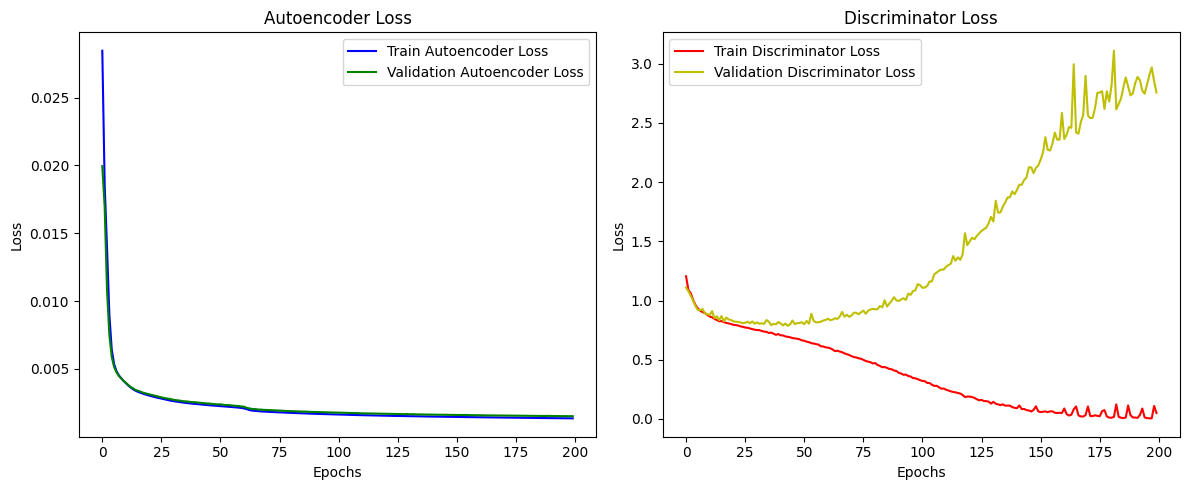

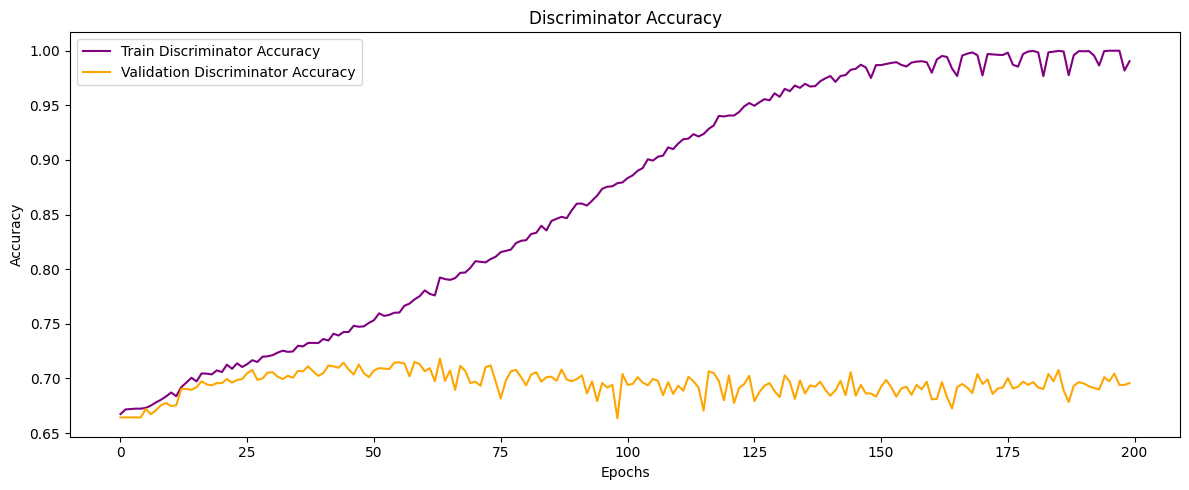

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the loss curves
def plot_loss_curves():
    plt.figure(figsize=(12, 5))

    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_losses_epoch, label="Train Autoencoder Loss", color="b")
    plt.plot(val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color="g")
    plt.title("Autoencoder Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator loss
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_losses_epoch, label="Train Discriminator Loss", color="r")
    plt.plot(val_discriminator_losses_epoch, label="Validation Discriminator Loss", color="y")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot discriminator accuracy
def plot_discriminator_accuracy():
    plt.figure(figsize=(12, 5))

    # Discriminator accuracy
    plt.plot(discriminator_acc_epoch, label="Train Discriminator Accuracy", color="purple")
    plt.plot(val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color="orange")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display generated images at regular intervals
def visualize_generated_images(epoch, generated_images, save_dir="generated_images"):
    # Save generated image at the end of the epoch
    if epoch % 10 == 0:  # Adjust frequency as needed
        plt.figure(figsize=(10, 10))
        for i in range(9):  # Display 9 images in a grid
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i])  # Assuming images are in 3x28x28 format
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_dir}/generated_images_epoch_{epoch}.png")
        plt.show()

# Visualize loss and accuracy
plot_loss_curves()
plot_discriminator_accuracy()

In [11]:
def evaluate_discriminator(discriminator, test_data):
    test_loss_disease = 0
    test_accuracy_disease = 0
    num_batches = len(test_data)

    for batch_real, batch_label in test_data:
        # Get the output from the discriminator (only disease classification)
        disease_output = discriminator(batch_real)  # Discriminator now outputs (batch_size, num_classes)
        
        # Ensure that the output has the correct shape for comparison
        if len(disease_output.shape) == 2:
            # Check if the output is of shape (batch_size, num_classes)
            print(f"Correct shape for disease_output: {disease_output.shape}")
        else:
            # If it's not, we should reshape it
            disease_output = tf.reshape(disease_output, (batch_real.shape[0], -1))
            print(f"Reshaped disease_output to: {disease_output.shape}")

        # Compute loss for disease classification
        loss_disc_disease = loss_fn_disc(batch_label, disease_output)  # Disease classification loss
        test_loss_disease += loss_disc_disease.numpy()

        # Calculate accuracy for disease classification
        accuracy_disease = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, disease_output))
        test_accuracy_disease += accuracy_disease.numpy()

    # Average losses and accuracy
    test_loss_disease /= num_batches
    test_accuracy_disease /= num_batches

    print(f"Test Loss (Disease): {test_loss_disease:.4f}")
    print(f"Test Accuracy (Disease): {test_accuracy_disease:.4f}")

# Evaluate the discriminator on the test data
evaluate_discriminator(discriminator, test_data)


Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: 